In [1]:
from typing import TypedDict, List, Optional
from langgraph.graph import MessagesState

class ConversationState(TypedDict):
    messages: MessagesState = []
    summary: str
    question: str
    response: str
    context: Optional[str]


In [2]:
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage

from langgraph.graph import MessagesState
from typing import Optional, Dict, Any
from langchain_google_genai import ChatGoogleGenerativeAI
from app.core.llm import large_llm, small_llm
from app.core.tools import doc_retriever_tool 
from langchain_core.messages import convert_to_messages
from app.core.prompt  import REWRITE_PROMPT, GENERATE_PROMPT
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


def generate_query_or_respond(state: ConversationState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    messages = state.get("messages", [])
    response = (
        large_llm
        .bind_tools([doc_retriever_tool]).invoke(state["question"])
    )
    return {**state, "messages": messages + [HumanMessage(content=state["question"]), response]}



d:\VR_PROJECT\bandoso-api\app\core\embedding.py:11: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
C:\Users\Deno\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded on: cpu


In [3]:
REWRITE_PROMPT = (
    "Look at the input and improve with a better question. Output with just imrpvoed question without comment, max it short\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    question = state["question"]
    prompt = REWRITE_PROMPT.format(question=question)
    response = small_llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [4]:

GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: ConversationState):
    """Generate an answer."""
    question = state["question"]
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    print("PRMOT:", prompt)
    response = large_llm.invoke([{"role": "user", "content": prompt}])
    print()
    return {**state, "messages":state["messages"] + [response], "response": response.content}

In [5]:

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(ConversationState)

workflow.add_node(generate_query_or_respond)
workflow.add_node(rewrite_question)
workflow.add_node("retrieve", ToolNode([doc_retriever_tool]))
workflow.add_node(generate_answer)
workflow.add_edge(START, "generate_query_or_respond")
workflow.add_conditional_edges(
    "generate_query_or_respond",
        tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile
memory = InMemorySaver()
graph = workflow.compile(
    checkpointer=memory
)

ValueError: Channel 'messages' already exists with a different type

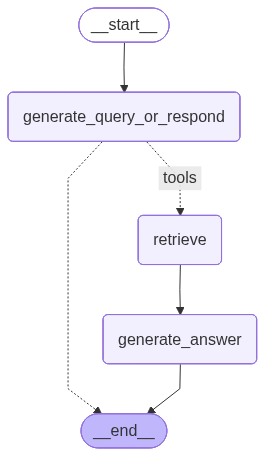

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
config = {"configurable": {"thread_id": "12"}}

state = {"question":"Vùng bưng 6 xã có j"}
for chunk in graph.stream(
    state,
    stream_mode="messages",
    config=config
):
    print(chunk)

(AIMessageChunk(content='', additional_kwargs={'function_call': {'name': 'doc_retriever_tool', 'arguments': '{"query": "V\\u00f9ng b\\u01b0ng 6 x\\u00e3"}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--b55645a2-324e-47ac-85dd-aae1fe9c0b0d', tool_calls=[{'name': 'doc_retriever_tool', 'args': {'query': 'Vùng bưng 6 xã'}, 'id': '0b60f78b-c84b-475c-92f7-24da65c7f7de', 'type': 'tool_call'}], usage_metadata={'input_tokens': 72, 'output_tokens': 94, 'total_tokens': 166, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 70}}, tool_call_chunks=[{'name': 'doc_retriever_tool', 'args': '{"query": "V\\u00f9ng b\\u01b0ng 6 x\\u00e3"}', 'id': '0b60f78b-c84b-475c-92f7-24da65c7f7de', 'index': None, 'type': 'tool_call_chunk'}]), {'thread_id': '12', 'langgraph_step': 6, 'langgraph_node': 'generate_query_or_respond', 'langgraph_triggers': ('branch:to:generate_query_or_respond',), 'langgraph_path': ('__pregel_p

In [ ]:
from app.core.query_cache import *


d:\VR_PROJECT\bandoso-api\app\core\embedding.py:11: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(
C:\Users\Deno\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded on: cpu


In [ ]:
add_to_cache("Đụ con đỉ mẹ chị", "Tin tức sáng nay đề cập về việc giá vàng tăng nhanh")

In [ ]:
find_in_cache("Đụ con đỉ mẹ chị")

[(Document(metadata={'answer': 'Tin tức sáng nay đề cập về việc giá vàng tăng nhanh', '_id': '79969627-9c81-476e-a969-433932240616', '_collection_name': 'cache'}, page_content='Đụ con đỉ mẹ chị'), 0.88246888)]


'Đụ con đỉ mẹ chị'